# Setup

## Load Modules

In [1]:
%matplotlib notebook

# Standard library
import os.path, logging, collections
import cPickle as pickle

# External modules
from neuron import h
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import bluepyopt.ephys as ephys

# Our modules
from bgcellmodels.mechanisms import noise, synapses
from bgcellmodels.common import electrotonic, treeutils, analysis, logutils
from bgcellmodels.morphology import morph_io # morph_gui, morph_ni

## Settings

In [2]:
# Global variables
nrnsim = ephys.simulators.NrnSimulator(dt=0.025, cvode_active=False)

logger = logging.getLogger('STN_MORPH')
logger.setLevel(logging.DEBUG)
logging.basicConfig(format=logutils.DEFAULT_FORMAT)

In [3]:
# Plotting options
page_width = 10.0
fig_aspect_ratio = 2.2 # 8.0 / 3.0
fig_width = 0.8 * page_width
fig_height = fig_width / fig_aspect_ratio

# Style of figures (default colors etc.): see https://matplotlib.org/gallery/style_sheets/style_sheets_reference.html
plt.style.use('default')

# fix bug for notebook backend where figures not shown
if matplotlib.get_backend() == 'nbAgg':
    from bgcellmodels.extensions.jupyter import jupyterutil
    jupyterutil.notebook_show_figs_after_exception()

## Functions

In [4]:
def get_sample(sec, i):
    return np.array([h.x3d(i, sec=sec), h.y3d(i, sec=sec), h.z3d(i, sec=sec), h.diam3d(i, sec=sec)])

def save_trace(trace_name, file_path, scale=1e-3):
    """
    Save trace to file
    """
    V_soma = np.array(vec_dict[trace_name], ndmin=2)
    T_soma = np.array(vec_dict['t_global'], ndmin=2)
    TV_soma = np.concatenate((T_soma, V_soma), axis=0) * scale # pyelectro expects SI units: seconds, Volts
    np.savetxt(file_path, TV_soma.T, delimiter=',', fmt=['%.3E', '%.7E'])
    print("Wrote trace to " + os.path.abspath(file_path))

def plot_soma_Vm():
    v_soma = vec_dict['V_soma'].as_numpy()
    t_rec = vec_dict['t_global'].as_numpy()

    plt.figure(figsize=(fig_width, fig_height))
    plt.plot(t_rec, v_soma)
    plt.ylim((-90, 50))
    plt.grid(True)

## Measurement

In [5]:
# get distance functions
distance_funcs = {
    'Ztransfer': electrotonic.measure_transfer_impedance,
    'Ai': electrotonic.measure_current_transfer,
    'Av': electrotonic.measure_voltage_transfer,
    'Zin': electrotonic.measure_input_impedance,
}

measures_ylims = {
    'Zin': (0, 2100.0),
    'Ztransfer': (40, 70),
    'Ai': (0.5, 1.05),
    'Av': (0, 1.1),
}

electrotonic_measures = {
    'Ztransfer': {
        'function': electrotonic.measure_transfer_impedance,
        'label': 'Transfer impedance',
        'units': 'Ohm',
    },
    'Ai': {
        'function': electrotonic.measure_current_transfer,
        'label': 'Current transfer ratio',
        'units': 'ratio',
    },
    'Av': {
        'function': electrotonic.measure_voltage_transfer,
        'label': 'Voltage transfer ratio',
        'units': 'ratio',
    },
    'Zin': {
        'function': electrotonic.measure_input_impedance,
        'label': 'Input impedance',
        'units': 'Ohm',
    }
}

def plot_electrotonic_structure(root, leaves, measures=None, freq=25.0):
    """
    Plot electrotonic properties along dendritic paths.
    """
    if measures is None:
        plotted_measures = electrotonic_measures.keys()
    else:
        plotted_measures = measures
    measure_funcs = {measure: electrotonic_measures[measure]['function'] for measure in plotted_measures}
        
    # Do measurement
    leaf_path_measurements = electrotonic.measure_along_paths(root, leaves, measure_funcs, freq=freq)

    # Plot measurements
    fig, axes = plt.subplots(len(plotted_measures))

    for i, measure in enumerate(plotted_measures):
        ax = axes[i]

        # Plot the same measure for each leaf in the same axis
        for j, leaf in enumerate(leaves):
            ax.plot(leaf_path_measurements[j]['pathlen_micron'],
                    leaf_path_measurements[j][measure],
                    label=leaf.name())

            # ax.set_ylim(measures_ylims[measure])
            # ax.legend()
            ax.grid(True)
            ax.set_ylabel('{} ({})'.format(measure, electrotonic_measures[measure]['units']))
            ax.set_title(electrotonic_measures[measure]['label'])
    
    # prevent clipped xlabel
    # fig.subplots_adjust(hspace=0.5)
    # fig.tight_layout()
    return leaf_path_measurements

# Gunay (2008) - PyNN cell

In [ ]:
from bgcellmodels.models.GPe.Gunay2008 import gunay_pynn_model as gunay
from bgcellmodels.models.axon.foust2011 import AxonFoust2011

# Load axon trajectory from diffusion streamlines
# streamlines_path = '/home/luye/Documents/mri_data/Waxholm_rat_brain_atlas/WHS_DTI_v1_ALS/S56280_ROI-STN-bilateral.tck'
# axon_coords = morph_ni.load_streamlines(streamlines_path, max_num=1, min_length=2.0)[0]

# Load axon trajectory from Blender splines
axonfile_splines = ('/home/luye/workspace/bgcellmodels/bgcellmodels/models/network/'
                    'LuNetDBS/configs/axons/axon_coordinates_collaterals.pkl')
with open(axonfile_splines, 'rb') as axon_file:
    all_axons = pickle.load(axon_file)
axon_coords = np.array(all_axons['axon.GPe-STN.nurbs.5']) * 1e-3
gpi_center_um = np.array([18533.4921875, 5821.53759765625, 7248.1533203125])

# Don't use axon
# axon_coords = []

# Cell parameters
cell_params = dict(gunay.GpeProtoCellType.default_parameters)
cell_params['owning_gid'] = 1
cell_params['membrane_noise_std'] = 0.1
## 3D Parameters
cell_params['transform'] = np.eye(4)
## Axon parameters
cell_params['streamline_coordinates_mm'] = axon_coords
cell_params['axon_class'] = AxonFoust2011
cell_params['collateral_branch_points_um'] = gpi_center_um.reshape((-1,3))
cell_params['collateral_target_points_um'] = gpi_center_um.reshape((-1,3))
cell_params['collateral_lvl_lengths_um'] = np.array([50.0, 50.0]).reshape((-1, 2)) 
cell_params['collateral_lvl_num_branches'] = np.array([1, 2]).reshape((-1, 2))
## FEM parameters
cell_params['with_extracellular'] = False

## Parameters for gap junction connection
# Axon configuration
# - if gap_pre_conductance = 1e-5, spontaneous spiking unaffected but antidromic spikes do not trigger spike in soma
# - if gap_pre_conductance = 1e-4, antidromic spike results in dV of 2.5 mV in soma
# - if gap_pre_conductance = 5e-4, antidromic spike results in dV of 15 mV in soma, but no spike
# - if gap_pre_conductance = 1e-3, antidromic spike results in somatic spike
# cell_params['axon_using_gap_junction'] = False
# cell_params['gap_pre_conductance'] = 1e-5 # g=0 means unidirectional soma->axon
# cell_params['gap_post_conductance'] = 1e-3
# cell_params['axon_taper_diam'] = .005

# instantiate cell
model = gunay.GpeProtoCellType.model(**cell_params)
icell = model.icell

# Write to PLY to check in Blender
# morph_io.morphology_to_PLY([icell.all], 'GPe_comp-locs.ply')

In [ ]:
# Get sections by region
named_seclists =  {listname: list(getattr(icell, listname)) for listname in model.seclist_names}
for k, v in named_seclists.items():
    if len(v)==0:
        named_seclists.pop(k) # don't include empty SectionLists
    else:
        print("{} : {} sections".format(k, len(v)))

somatic = named_seclists['somatic']
dendritic = named_seclists['basal']

soma = somatic[0]
dend = dendritic[0]

if model.with_axon:
    axonal = list(model.axon.all)
else:
    axonal = []
    
# Representative sections picked from morphology viewer
distal_seg = dendritic[31](0.8)
middle_seg = dendritic[25](0.5)
proximal_seg = dendritic[0](0.5)

# Gunay (2008) - Ephys cell

In [6]:
from bgcellmodels.models.GPe.Gunay2008 import gunay_model

ephys_cell, nrnsim = gunay_model.create_cell(
    model=gunay_model.MODEL_GUNAY2008_AXONLESS)

model = ephys_cell
icell = ephys_cell.icell
model.with_axon = False

somatic = list(icell.somatic)
dendritic = list(icell.basal) + list(icell.apical)
axonal = list(icell.axonal)

soma = somatic[0]
distal_seg = dendritic[31](0.8)
middle_seg = dendritic[25](0.5)
proximal_seg = dendritic[0](0.5)

print('Trunk sections: {}'.format(soma.children()))
h.topology()

[WARNING::pint.util@registry.py:324] Redefining 'mho' (<class 'pint.definitions.UnitDefinition'>)


Using units module 'pint'
Trunk sections: [GPe[0].dend[22], GPe[0].dend[11], GPe[0].dend[0], GPe[0].axon[0]]

|-|       GPe[0].soma[0](0-1)
  `--|       GPe[0].axon[0](0-1)
  `|       GPe[0].dend[0](0-1)
    `----|       GPe[0].dend[1](0-1)
          `|       GPe[0].dend[2](0-1)
          `------|       GPe[0].dend[3](0-1)
                  `--|       GPe[0].dend[4](0-1)
                      `|       GPe[0].dend[5](0-1)
                        `|       GPe[0].dend[6](0-1)
                        `|       GPe[0].dend[7](0-1)
                      `|       GPe[0].dend[8](0-1)
                  `--|       GPe[0].dend[9](0-1)
    `--------|       GPe[0].dend[10](0-1)
  `--------|       GPe[0].dend[11](0-1)
            `|       GPe[0].dend[12](0-1)
              `|       GPe[0].dend[13](0-1)
              `----|       GPe[0].dend[14](0-1)
                    `|       GPe[0].dend[15](0-1)
                    `|       GPe[0].dend[16](0-1)
            `--|       GPe[0].dend[17](0-1)
         

1.0

In [7]:
# Measure original electrotonic properties as reference
leaves = treeutils.leaf_sections(soma, subtree=True)
root = icell.soma[0]

leaf_distance_measures = electrotonic.measure_along_paths(root, leaves, distance_funcs, freq=25.0)

# Gunay (2008) - reduced

In [8]:
from bgcellmodels.models.GPe.Gunay2008.reduced import gunay_reduced

# Re-use original model if created
try:
    model = ephys_cell
except NameError:
    model = None

# Morphology reduction of original cell
reduction = gunay_reduced.make_reduction(
                gunay_reduced.ReductionMethod.BushSejnowski,
                ephys_model=model,
                reduction_params={'split_dX': 1.0})

reduction.reduce_model(num_passes=1, map_synapses=False)
# h.define_shape()

# Sections by name
somatic = [ref.sec for ref in reduction._soma_refs]
dendritic = [ref.sec for ref in reduction._dend_refs]
axonal = [ref.sec for ref in reduction._axon_refs]

soma = somatic[0]
for sec in dendritic:
    if sec not in model.icell.basal:
        model.icell.basal.append(sec=sec)

model.with_axon = False # there is no full axon
model.with_reduction = True

# Representative sections picked from morphology viewer
distal_seg = dendritic[5](0.8)
middle_seg = dendritic[0](0.8)
proximal_seg = dendritic[3](0.5)

h.topology()

Equivalent cylinders at subtree root GPe[0].dend[0](1): [0.9999999999880002, 0.9999999999920001, 0.999999999994, 0.9999999999979999, 0.9999999999979999] 
Equivalent cylinders at subtree root GPe[0].dend[11](1): [0.9999999999979999, 0.999999999995, 0.999999999998] 
Equivalent cylinders at subtree root GPe[0].dend[22](1): [0.9999999999860002, 0.9999999999900001, 0.9999999999890001, 0.9999999999900002, 0.999999999996, 0.999999999998] 

|-|       GPe[0].soma[0](0-1)
  `--|       GPe[0].axon[0](0-1)
  `|       GPe[0].dend[0](0-1)
    `|       zipA0(0-1)
      `|       zipA1(0-1)
        `|       zipA2(0-1)
          `|       zipA3(0-1)
            `|       zipA4(0-1)
  `--------|       GPe[0].dend[11](0-1)
            `|       zipB0(0-1)
              `|       zipB1(0-1)
                `|       zipB2(0-1)
  `--|       GPe[0].dend[22](0-1)
      `|       zipC0(0-1)
        `|       zipC1(0-1)
          `|       zipC2(0-1)
            `|       zipC3(0-1)
              `|       zipC4(0-1)
   

1.0

In [29]:
dendritic[3].psection()

{'Ra': 174.0,
 'cell': None,
 'cm': [4.800000000000002],
 'density_mechs': {'CaHVA': {'gmax': [0.00018000000000000004],
   'iCaH': [-0.0008761868021375972],
   'm': [0.0027040155774906483]},
  'Calcium': {'cai0': [5e-05], 'depth': [1600000000000.0], 'tau': [1.0]},
  'HCN': {'gmax': [0.00020000000000000006],
   'iHCN': [-1.1893412246927607e-05],
   'ih': [-1.1893412246927607e-05],
   'm': [0.0018971838112470723]},
  'HCN2': {'gmax': [0.0005000000000000002],
   'iHCN': [-6.50287200018869e-06],
   'ih': [-6.50287200018869e-06],
   'm': [0.00041492644868779794]},
  'KCNQ': {'gmax': [0.00040000000000000013],
   'iKCNQ': [0.0006946146239502463],
   'm': [0.49618978548417014]},
  'Kv2': {'gmax': [0.00020000000000000006],
   'h': [0.9881751399149098],
   'iKv2': [1.8682839204737433e-08],
   'm': [0.04263660300027352]},
  'Kv3': {'gmax': [0.002000000000000001],
   'h': [0.9892437719327247],
   'iKv3': [6.740185896981523e-10],
   'm': [0.010447304608830268]},
  'Kv4f': {'gmax': [0.00800000000000

# Electrotonic structure

In [ ]:
# from neuron import gui
# h.topology()

In [ ]:
# First draw skeleton to get an idea
# plt.figure()
# ax = plt.subplot(111, projection='3d')
# ax.view_init(90,90) # set azimut and elevation
# ax.set_zlim((-1,1)) # prevent rounding errors
# ax.set_axis_off() # hide x,y,z axes and grid

# # center = np.array([h.x3d(0, sec=soma), h.y3d(0, sec=soma), h.z3d(0, sec=soma)])
# x_soma = h.x3d(0, sec=soma)
# y_soma = h.y3d(0, sec=soma)
# ax.set_xlim((x_soma-200, x_soma+200))
# ax.set_ylim((y_soma-200, y_soma+200))


# # Plot shape of our cell
# morph_gui.shapeplot(h, ax)

# # Mark location of leaf section to refer to plots
# marker_colors = 'rgby'
# for i, leaf_sec in enumerate(leaves):
#     morph_gui.mark_locations(h, leaf_sec, 1.0, 
#                              label=leaf_sec.name(),
#                              markspec='o'+marker_colors[i])

# plt.legend()
# plt.show()

In [ ]:
# Measure Zin at soma
soma_Zin = {
    f : electrotonic.measure_input_impedance(soma(0.5), freq=f, linearize_gating=False)
                for f in (0.0, 100.0)
}

print("""Values without axon are:
        Zin(f=0.0) = 10244.5768497 (MOhm)
        Zin(f=100.0) = 514.248538756 (MOhm)\n""")

print("Somatic input impedances are: \n\t" + "\n\t".join(
        ["Zin(f={}) = {} (MOhm)".format(f, Z) for f,Z in soma_Zin.items()]))


In [ ]:
# Measure Z/A
# leaf_distance_measures = electrotonic.measure_along_paths(root, leaves, distance_funcs, freq=25.0)
measurements = plot_electrotonic_structure(root, leaves)

## ARTICLE figure

In [ ]:
soma.diam = 1.00 - 0.0008

In [10]:
root = icell.soma[0]
leaves = treeutils.leaf_sections(soma, subtree=True)

leaf_distance_measures_old = leaf_distance_measures
leaf_distance_measures_new = electrotonic.measure_along_paths(root, leaves, distance_funcs, freq=25.0)

<IPython.core.display.Javascript object>


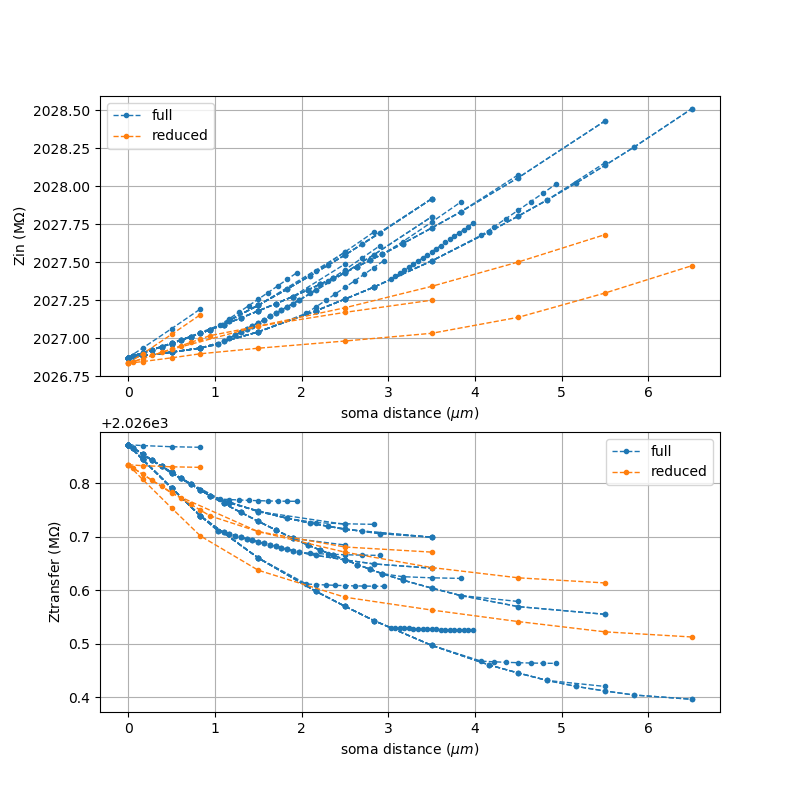

Figure saved to file /home/luye/cloudstore_m/notes/publications_lkmn/ARTICLE_reduction/figures/gpe-full-vs-red_Zin-Ztr.pdf


'/home/luye/cloudstore_m/notes/publications_lkmn/ARTICLE_reduction/figures/gpe-full-vs-red_Zin-Ztr.pdf'

In [11]:
from bgcellmodels.common import plotutils

plotted_measures = ['Zin', 'Ztransfer']

measures_ylims['Zin'] = (2026.4, 2029)
measures_ylims['Ztransfer'] = (2026.25, 2027)

fig, axes = plt.subplots(len(plotted_measures), figsize=(8.0, 8.0))

for i, measure in enumerate(plotted_measures):
    ax = axes[i]
    
    # Plot the same measure for each leaf in the same axis
    for j, leaf_dist_measures in enumerate(leaf_distance_measures_old):
        
        ax.plot(
            leaf_dist_measures['pathlen_micron'],
            leaf_dist_measures[measure],
            '--', marker='.', linewidth=1.0, color=plotutils.get_style_colors()[0],
            label='full' if j==0 else None)
        
    for j, leaf_dist_measures in enumerate(leaf_distance_measures_new):
        
        ax.plot(
            leaf_dist_measures['pathlen_micron'],
            leaf_dist_measures[measure],
            '--', marker='.', linewidth=1.0, color=plotutils.get_style_colors()[1],
            label='reduced' if j==0 else None)
        
    # ax.set_ylim(measures_ylims[measure])
    ax.legend() # show line labels
    ax.grid(True)
    ax.set_ylabel('{} (M$ \Omega $)'.format(measure))
    ax.set_xlabel('soma distance ($\mu m$)')

plotutils.save_figure(
    'gpe-full-vs-red_Zin-Ztr', fig=fig,
    dir='/home/luye/cloudstore_m/notes/publications_lkmn/ARTICLE_reduction/figures')

# Protocols

## Protocol Setup

### Functions -  clamp

In [12]:
def setup_protocol_SPONT():
    """
    Edgerton 2010, Fig. 2

    Spontaneous firing for Arkypallidal cells in shown in:

        Abdi, Mallet et al (2015), Fig. 7 : f = 3 Hz
        Bogacz, Moraud, et al (2016), Fig. 3 : f = 2 Hz
    """
    h.dt = 0.025
    h.tstop = 1000.0
    
    h.celsius = 35.0
    h.v_init = -68.0
    
    h.init()
    # h.run()
    # nrnsim.run(h.tstop, h.dt)
    
    return {}


def setup_protocol_POSPULSE(icell, scale=1.0):
    """
    Stimulation with 100 pA

    See article Gunay (2008), Fig. 1 and Fig. 2.
    """
    # Amplitude adjustment: soma surface was changed by factor 1 / 13.4^2 == pi*1^2 / pi*13.4^2
    # However: remaining compartments were changed by smaller factor, so this is not good adjustment
    surf_factor = 0.01 * scale
    stim = h.IClamp(soma(0.5))
    stim.delay = 1000
    stim.dur = 1000
    stim.amp = 0.1 * surf_factor # 100 pA = 0.1 nA

    h.dt = 0.025
    h.tstop = 3000.0
    
    h.celsius = 35.0
    h.v_init = -68.0
    
    h.init()
    
    return {'electrodes': [stim]}


def setup_protocol_NEGPULSE(icell, scale=1.0):
    """
    Stimulation with -100 pA

    See article Gunay (2008), Fig. 1 and Fig. 2.
    """
    # Amplitude adjustment: soma surface was changed by factor 1 / 13.4^2 == pi*1^2 / pi*13.4^2
    # However: remaining compartments were changed by smaller factor, so this is not good adjustment
    surf_factor = 0.02 * scale
    stim = h.IClamp(soma(0.5))
    stim.delay = 1000
    stim.dur = 1000
    stim.amp = -0.1 * surf_factor # 100 pA = 0.1 nA
    
    h.dt = 0.025
    h.tstop = 3000.0
    
    h.celsius = 35.0
    h.v_init = -68.0
    
    h.init()
    
    return {'electrodes': [stim]}

def setup_protocol_ANTIDROMIC(cellmodel, amp=0.05, dur=200.0):
    """
    stimulation of axon.
    """
    sec = cellmodel.axon['node'][10]
    
    surf_factor = 1.0
    stim = h.IClamp(sec(0.5))
    stim.delay = 500
    stim.dur = dur
    stim.amp = amp # (nA) e.g. 0.1 nA = 100 pA

    h.dt = 0.025
    h.tstop = 1000.0
    
    h.celsius = 35.0
    h.v_init = -68.0
    
    h.init()
    
    return {'electrodes': [stim]}

### Functions - synaptic

In [ ]:
def setup_protocol_SYN_EXH_INH(
        cellmodel, segments, rate=50, noise=0, num_spikes=1e9, tstart=0, 
        scale_gsyn=1.0, memb_noise_std=0.0,
        intraburst_rate=0, interburst_interval=200, 
        burst_duration=50.0, burst_noise=1.0):

    # Clear previous inputs
    stim_data = {}
    stim_data['GPE'] = {}
    stim_data['GPE']['synapses'] = []
    stim_data['GPE']['netstims'] = []
    stim_data['GPE']['netcons'] = []
    
    if isinstance(tstart, (float, int)):
        tstart = [tstart]*len(segments)
    
    # Make new inputs
    for i, seg in enumerate(segments):
        syn = h.GABAsyn2(seg)
        stim_data['GPE']['synapses'].append(syn)
        
        # One spike generator for background spikes
        stim = h.NetStim()
        stim.interval = rate**-1*1e3
        stim.number = num_spikes
        stim.noise = noise
        stim.start = tstart[i]
        
        nc = h.NetCon(stim, syn)
        nc.delay = 1.0
        nc.weight[0] = 1.0
        
        stim_data['GPE']['netstims'].append(stim)
        stim_data['GPE']['netcons'].append(nc)
        
        # One spike generator for bursts (does not spike between bursts)
        if intraburst_rate != 0:
            bstim = h.BurstStim()
            bstim.fast_invl = intraburst_rate ** -1 * 1e3
            bstim.slow_invl = interburst_interval
            bstim.burst_len = burst_duration * 1e-3 * intraburst_rate
            bstim.start = tstart[i]
            bstim.noise = burst_noise
            
            bnc = h.NetCon(bstim, syn)
            bnc.delay = 1.0
            bnc.weight[0] = 1
            
            stim_data['GPE']['netstims'].append(bstim)
            stim_data['GPE']['netcons'].append(bnc)
        
        # Parameters from config
        syn.U1 = 0.2
        syn.tau_rec = 400.0
        syn.tau_facil = 1.0
        # GABA-A
        syn.gmax_GABAA = 2e-4 * scale_gsyn
        syn.tau_r_GABAA = 2.0
        syn.tau_d_GABAA = 5.0
        # GABA-B
        syn.gmax_GABAB = 0.4e-4 * scale_gsyn
        syn.tau_r_GABAB = 5.0
        syn.tau_d_GABAB = 25.0
        # Hill kinetics
        syn.K3 = 0.098
        syn.K4 = 0.00625
        syn.KD = 1.4
        syn.n = 4.0
        
    # Set up membrane noise
    rng = h.Random()
    rng.MCellRan4(1, 2)
    rng.normal(0, 1)

    soma = cellmodel.icell.soma[0]
    stim = h.ingauss2(soma(0.5))
    std_scale =  1e-2 * sum((seg.area() for seg in soma)) # [mA/cm2] to [nA]
    stim.mean = 0.0
    stim.stdev = memb_noise_std * std_scale
    stim.noiseFromRandom(rng)
    
    stim_data['GPE']['noise'] = (rng, stim)
    
    # Simulation settings
    h.dt = 0.025
    h.tstop = 1000.0
    h.celsius = 35.0
    h.v_init = -68.0
    h.init()
    
    return stim_data

### Recordings

In [13]:
rec_secs = {
    'soma': soma,
    'prox': proximal_seg,
    'mid': middle_seg,
    'dist': distal_seg,
    
}

if model.with_axon:
    axon_leaf_secs = treeutils.leaf_sections(axonal[0], subtree=True)
    assert len(axon_leaf_secs) == 1, "More than one axon terminal section."
    axon_terminal = axon_leaf_secs[0]
    
    rec_secs.update({
        # Axon sections
        'ax_prox': model.axon['node'][3], # axonal[int(0.2 * len(axonal))],
        'ax_mid': model.axon['node'][6], # axonal[int(0.5 * len(axonal))],
        'ax_dist': model.axon['node'][9], # axonal[int(0.8 * len(axonal))],
        'ax_term': axon_terminal,
    })

In [14]:
trace_specs = collections.OrderedDict([
    ('t_global', {'var':'t'}),
    # Cell body and dendrites
    ('V_soma', {'var':'v', 'sec':'soma', 'loc':0.5}),
    ('V_prox', {'var':'v', 'seg':'prox'}),
    ('V_mid', {'var':'v', 'seg':'mid'}),
    ('V_dist', {'var':'v', 'seg':'dist'}),
    
])

if model.with_axon:
    trace_specs.update([
        # Axonal sections
        ('V_axprox', {'var':'v', 'sec':'ax_prox', 'loc':0.5}),
        ('V_axmid', {'var':'v', 'sec':'ax_mid', 'loc':0.5}),
        ('V_axdist', {'var':'v', 'sec':'ax_dist', 'loc':0.5}),
        ('V_axterm', {'var':'v', 'sec':'ax_term', 'loc':0.5}),
    ])

# Record
rec_dt = 0.05
vec_dict, markers = analysis.recordTraces(rec_secs, trace_specs, rec_dt)

## Modify Cell

In [15]:
print("""Original:
-------------------------------

somatic:  	gmax_CaHVA = 0.000030
somatic:  	gmax_Kv4s = 0.003000
somatic:  	gmax_HCN = 0.000100
somatic:  	g_pas = 0.000068
somatic:  	gmax_NaF = 0.035000
somatic:  	gmax_HCN2 = 0.000250
somatic:  	gmax_KCNQ = 0.000200
somatic:  	gmax_SK = 0.006400
somatic:  	gmax_Kv4f = 0.002000
somatic:  	gmax_NaP = 0.000102
somatic:  	gmax_Kv2 = 0.000100
somatic:  	gmax_Kv3 = 0.001000

basal:  	gmax_CaHVA = 0.000030
basal:  	gmax_Kv4s = 0.006000
basal:  	gmax_HCN = 0.000100
basal:  	g_pas = 0.000068
basal:  	gmax_NaF = 0.035000
basal:  	gmax_HCN2 = 0.000250
basal:  	gmax_KCNQ = 0.000200
basal:  	gmax_SK = 0.000040
basal:  	gmax_Kv4f = 0.004000
basal:  	gmax_NaP = 0.000102
basal:  	gmax_Kv2 = 0.000100
basal:  	gmax_Kv3 = 0.001000

axonal:  	gmax_Kv4s = 0.240000
axonal:  	g_pas = 0.000068
axonal:  	gmax_NaF = 0.500000
axonal:  	gmax_KCNQ = 0.000040
axonal:  	gmax_Kv4f = 0.160000
axonal:  	gmax_NaP = 0.004000
axonal:  	gmax_Kv2 = 0.064000
axonal:  	gmax_Kv3 = 0.128000
""")

print("""Current:
-------------------------------""")

for seclist in 'somatic', 'basal', 'axonal':
    sections = list(getattr(icell, seclist))
    print('')
    for sec in sections:
        printed = False
        for mech, pnames in gunay_model.mechs_params_dict.items():
            if not h.ismembrane(mech, sec=sec):
                continue
            for pname in pnames:
                rangevar = pname + '_' + mech if mech != '' else pname
                print("%s:  \t%s = %f" % (seclist, rangevar, getattr(sec, rangevar)))
                printed = True
        if printed:
            break

Original:
-------------------------------

somatic:  	gmax_CaHVA = 0.000030
somatic:  	gmax_Kv4s = 0.003000
somatic:  	gmax_HCN = 0.000100
somatic:  	g_pas = 0.000068
somatic:  	gmax_NaF = 0.035000
somatic:  	gmax_HCN2 = 0.000250
somatic:  	gmax_KCNQ = 0.000200
somatic:  	gmax_SK = 0.006400
somatic:  	gmax_Kv4f = 0.002000
somatic:  	gmax_NaP = 0.000102
somatic:  	gmax_Kv2 = 0.000100
somatic:  	gmax_Kv3 = 0.001000

basal:  	gmax_CaHVA = 0.000030
basal:  	gmax_Kv4s = 0.006000
basal:  	gmax_HCN = 0.000100
basal:  	g_pas = 0.000068
basal:  	gmax_NaF = 0.035000
basal:  	gmax_HCN2 = 0.000250
basal:  	gmax_KCNQ = 0.000200
basal:  	gmax_SK = 0.000040
basal:  	gmax_Kv4f = 0.004000
basal:  	gmax_NaP = 0.000102
basal:  	gmax_Kv2 = 0.000100
basal:  	gmax_Kv3 = 0.001000

axonal:  	gmax_Kv4s = 0.240000
axonal:  	g_pas = 0.000068
axonal:  	gmax_NaF = 0.500000
axonal:  	gmax_KCNQ = 0.000040
axonal:  	gmax_Kv4f = 0.160000
axonal:  	gmax_NaP = 0.004000
axonal:  	gmax_Kv2 = 0.064000
axonal:  	gmax_Kv3 = 

AttributeError: 'CellModel' object has no attribute '_mechs_params_dict'

In [20]:
def compensate_loading(method='axon'):
    """
    Change cell body properties to compensate reduction in input impedance
    caused by axon attachment or morphology reduction.
    
    @param    model : str
              'axon' or 'reduction'
    """
    
    ais = list(icell.axonal)[0]
    # myis = list(model.axon.all)[0]

    # Increase size from 1 um -> decrease influence of axon on firing properties
    print('\nDiameters (pre):')
    print(soma.diam)
    print(ais.diam)
    # soma.diam = 1.0
    # ais.diam = 1.0
    # myis.diam = 1.0
    
    print('\nLengths (pre):')
    print(soma.L)
    print(ais.L)
    # soma.L = 1
    # ais.L = 1
    
    # Increase NaP density -> need higher persistent current to compensate for Zin decrease
    gbar_scaling_axonmodel = {
        'basal':    {'gmax_NaP':  {'default': 0.000102, 'scale': 1.0}},
        'somatic' : {
            'gmax_NaP':  {'default': 0.000102, 'scale': 6.0},
#             'gmax_NaF':  {'default': 0.035000, 'scale': 1.0},
#             'gmax_HCN':  {'default': 0.000100, 'scale': 0.1},
#             'gmax_HCN2': {'default': 0.000250, 'scale': 0.1},
#             'gmax_KCNQ': {'default': 0.000200, 'scale': 0.1},
#             'gmax_SK':   {'default': 0.006400, 'scale': 0.1},
#             'gmax_Kv4f': {'default': 0.002000, 'scale': 0.1},
#             'gmax_Kv4s': {'default': 0.003000, 'scale': 0.1},
#             'gmax_Kv2':  {'default': 0.000100, 'scale': 0.1},
#             'gmax_Kv3':  {'default': 0.001000, 'scale': 0.1},
#             'gmax_CaHVA':{'default': 0.000030, 'scale': 0.1},
        },
        'axonal':   {'gmax_NaP':  {'default': 0.004000, 'scale': 6.0}},
    }
    
    gbar_scaling_reduction = {
        'basal':    {'gmax_NaP':  {'default': 0.000102, 'scale': 1.0}},
        'somatic' : {'gmax_NaP':  {'default': 0.000102, 'scale': 1.0}},
        'axonal':   {'gmax_NaP':  {'default': 0.004000, 'scale': 1.0}},
    }
    
    if method is None:
        print('No Zin compensation performed.')
        return
    elif method == 'axon':
        gbar_scaling = gbar_scaling_axonmodel
    elif method == 'reduction':
        gbar_scaling = gbar_scaling_reduction
    
    print('\nCompensating for Zin difference in model "{}"'.format(method))

    for seclist in gbar_scaling.keys():
        secs  = getattr(icell, seclist)
        for gname, gdata in gbar_scaling[seclist].items():
            gscale = gdata['scale']
            gbase = gdata['default']
            for sec in secs:
                if h.ismembrane(gname.split('_')[1], sec=sec):
                    for seg in sec:
                        setattr(seg, gname, gbase * gscale)


In [21]:
# Comment once compensation hardcoded in model
compensation = None
if model.with_axon:
    compensation = 'axon'
if model.with_reduction:
    compensation = 'reduction'
    
compensate_loading(compensation)


Diameters (pre):
1.0
1.0

Lengths (pre):
1.0
1.0

Compensating for Zin difference in model "reduction"


## Protocol SPONT

In [22]:
# Edgerton 2010, Fig. 2
# Spontaneous firing for Arkypallidal cells in shown in:
#     - Abdi, Mallet et al (2015), Fig. 7 : f = 3 Hz
#     - Bogacz, Moraud, et al (2016), Fig. 3 : f = 2 Hz
protocol = setup_protocol_SPONT()
h.run()

0.0

<IPython.core.display.Javascript object>


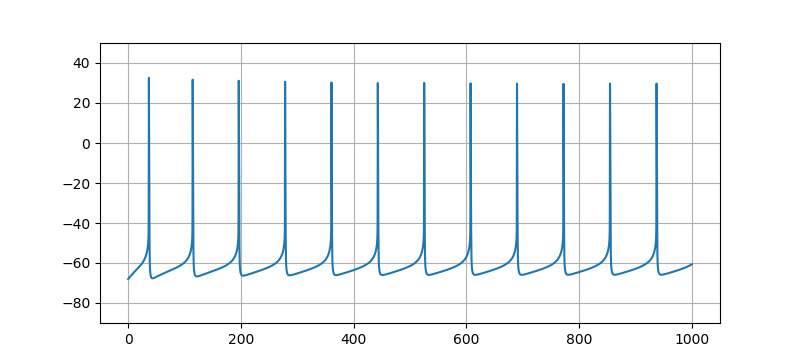

In [23]:
plot_soma_Vm()

In [ ]:
figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True, excludeTraces='t_global')
# save_trace('V_soma', 'v_soma_SPONT_mV_ms.csv', scale=1.0)

## Protocol POSPULSE

In [24]:
# Stimulation with +100 pA
# See article Gunay (2008), Fig. 1 and Fig. 2.
scale_amp = 2.0 if model.with_axon else 1.0
protocol = setup_protocol_POSPULSE(icell, scale=scale_amp)
h.run()
# NOTE: with axon (diam = 1.0, L unscaled), must scale excitatory pulse by 2.0 to obtain same rate

0.0

<IPython.core.display.Javascript object>


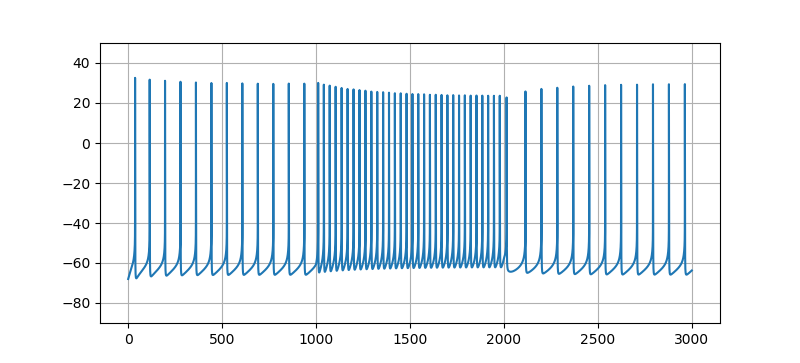

<IPython.core.display.Javascript object>


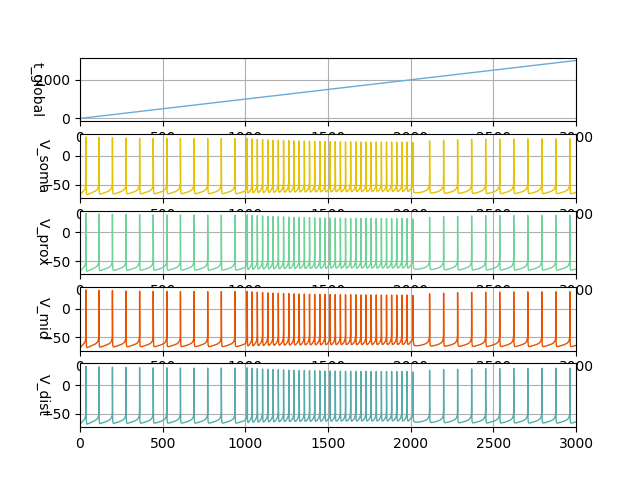

In [25]:
plot_soma_Vm()
figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True)

## Protocol NEGPULSE

In [26]:
# Stimulation with -100 pA
# See article Gunay (2008), Fig. 1 and Fig. 2.
scale_amp = 4.0 if model.with_axon else 1.0
protocol = setup_protocol_NEGPULSE(icell, scale=scale_amp)
h.run()
# NOTE: with axon (diam = 1.0, L unscaled), scale pulse amplitude by 4.0 yields similar
#       trace shape but everything shifted by -10 mV (like spontaneous APs)

0.0

<IPython.core.display.Javascript object>


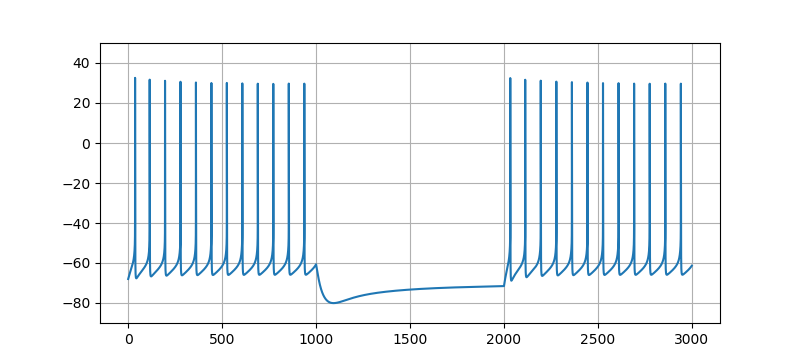

<IPython.core.display.Javascript object>


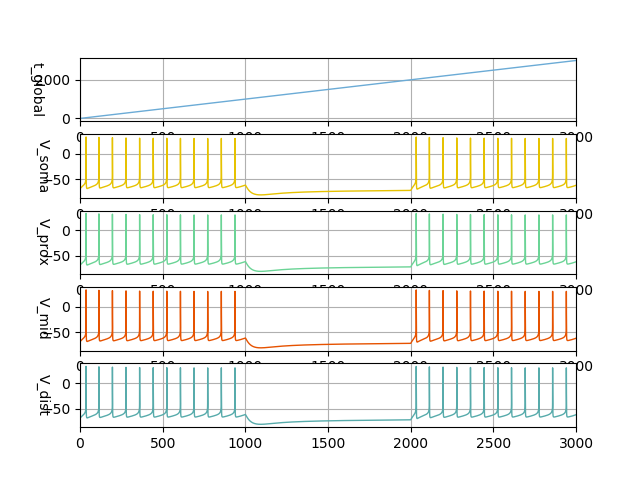

In [27]:
plot_soma_Vm()
figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True)

## Protocol ANTIDROMIC

In [ ]:
# Disable spontaneous spiking in
for sec in icell.all:
    if h.ismembrane('NaP', sec=sec):
        sec.gmax_NaP = 0.0

In [ ]:
protocol = setup_protocol_ANTIDROMIC(model, dur=5.0)
h.run()

In [ ]:
plot_soma_Vm()
figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True)

## Protocol SYN-EXC-INH

In [ ]:
syn_segments = [proximal_seg]
scale_amp = 4.0 if model.with_axon else 1.0

protocol = setup_protocol_SYN_EXH_INH(
                model, syn_segments, tstart=100, memb_noise_std=0.0,
                scale_gsyn=scale_amp)
h.run()

In [ ]:
plot_soma_Vm()
# figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True, excludeTraces='t_global')

# Save Notebook

In [ ]:
%%javascript
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});

In [ ]:
from datetime import datetime
nb_filename = 'calibrate_morphologies_GPe.ipynb'
report_filename = 'calibrate_morphologies_GPe_{}.html'.format(datetime.now().strftime('%Y.%m.%d_%H.%M.%S'))
!jupyter nbconvert $nb_filename --to html --template=toc2 --output $report_filename